In [1]:
import numpy as np

In [4]:
A, B = np.meshgrid(np.arange(10), np.arange(10, 20))

In [11]:
Ai, Bi

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19]))

In [9]:
for Ai, Bi in zip(A[], B):
    print(Ai, Bi)

[0 1 2 3 4 5 6 7 8 9] [10 10 10 10 10 10 10 10 10 10]
[0 1 2 3 4 5 6 7 8 9] [11 11 11 11 11 11 11 11 11 11]
[0 1 2 3 4 5 6 7 8 9] [12 12 12 12 12 12 12 12 12 12]
[0 1 2 3 4 5 6 7 8 9] [13 13 13 13 13 13 13 13 13 13]
[0 1 2 3 4 5 6 7 8 9] [14 14 14 14 14 14 14 14 14 14]
[0 1 2 3 4 5 6 7 8 9] [15 15 15 15 15 15 15 15 15 15]
[0 1 2 3 4 5 6 7 8 9] [16 16 16 16 16 16 16 16 16 16]
[0 1 2 3 4 5 6 7 8 9] [17 17 17 17 17 17 17 17 17 17]
[0 1 2 3 4 5 6 7 8 9] [18 18 18 18 18 18 18 18 18 18]
[0 1 2 3 4 5 6 7 8 9] [19 19 19 19 19 19 19 19 19 19]


In [7]:
test = np.stack((A, B))
for t in test:
    print(t)

[[0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]
 [0 1 2 3 4 5 6 7 8 9]]
[[10 10 10 10 10 10 10 10 10 10]
 [11 11 11 11 11 11 11 11 11 11]
 [12 12 12 12 12 12 12 12 12 12]
 [13 13 13 13 13 13 13 13 13 13]
 [14 14 14 14 14 14 14 14 14 14]
 [15 15 15 15 15 15 15 15 15 15]
 [16 16 16 16 16 16 16 16 16 16]
 [17 17 17 17 17 17 17 17 17 17]
 [18 18 18 18 18 18 18 18 18 18]
 [19 19 19 19 19 19 19 19 19 19]]


In [1]:
import numpy as np
from scipy.special import spence
from scipy.optimize import fmin,differential_evolution,minimize
from scipy.optimize import newton
import scipy as sp
import scipy.interpolate as interpolate
# from .params import cosmo_params

# from colossus.cosmology import cosmology
# params = {'flat': True, 'H0': 100*cosmo_params['hh'], 'Om0': cosmo_params['Omega_m'], 'Ob0': cosmo_params['Omega_b'], 'sigma8': 0.81, 'ns': 0.95}
# cosmology.addCosmology('myCosmo', **params)
# cosmo = cosmology.setCosmology('myCosmo', **params)
# cosmo = cosmology.setCosmology('planck18')
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck18')
cosmo_params = {
	'Omega_m':cosmo.Om0,
	'hh':cosmo.H0/100.,
	'Omega_L':1 - cosmo.Om0,
	'Omega_b':cosmo.Ob0,
	# 'rhoc_0':2.77525e2,
	# 'C_OVER_HUBBLE':2997.9
}


delx = 0.01
Msol_cgs = 1.989e33
Gravity = 6.67259e-8
rhocrit =  1.87847e-29 * cosmo_params['hh']**2
rhom =  rhocrit * cosmo_params['Omega_m']
C_CGS = 2.99792e+10
kpc_cgs = 3.086e21

fb = cosmo_params['Omega_b']/cosmo_params['Omega_m']




In [2]:
# cosmo.H0


In [16]:
class OBB:
    def __init__(self, M, z, gamma, conc=None, mdef='200c', r500c_Mpc_h=None, r200m_Mpc_h=None):
        self.Msol_cgs = 1.989e33
        self.M = M
        self.z = z
        if conc is None:
            self.c = 5.71 / (1 + self.z)**(0.47) * (self.M / 2e12)**(-0.084)
        else:
            self.c = conc
        self.gamma = gamma
        self.M_cgs = self.M*self.Msol_cgs
        om = cosmo_params['Omega_m']
        ol = cosmo_params['Omega_L']
        Ez2 = om * (1 + self.z)**3 + ol
        self.r200 = (3 * self.M_cgs / (4 * np.pi * 200.*rhocrit*Ez2))**(1.0/3.0)
        # self.r500 = (3 * self.M_cgs / (4 * np.pi * 500.*rhocrit*Ez2))**(1.0/3.0)
        self.r200c_Mpc_h = (self.r200 / (1e3 * kpc_cgs))*cosmo_params['hh']
        self.r500c_Mpc_h = r500c_Mpc_h
        self.r200m_Mpc_h = r200m_Mpc_h
        # self.r500c = self.r500c_Mpc_h / cosmo_params['hh'] * (1e3 * kpc_cgs)
        # self.r500c_Mpc_h = (self.r500 / (1e3 * kpc_cgs))*cosmo_params['hh']


    def nfw(self, x):
        '''shape of a NFW profile (NFW 1997, ApJ,490, 493)
        '''
        ans = 1./(x*(1 + x)**2)
        return ans

    def gx(self, x):
        ans = (np.log(1. + x) - x/(1. + x))
        return ans

    def gc(self, c):
        ans = 1./(np.log(1. + c) - c/(1. + c))
        return ans

    def Hc(self, c):
        ans = (-1.*np.log(1 + c)/(1. + c) + c*(1. + 0.5*c)/((1. + c)**2))/self.gx(c)
        return ans

    def Sc(self, c):
        ans = (0.5*np.pi**2 - np.log(c)/2. - 0.5/c - 0.5/(1 + c)**2 - 3/(1 + c) +
            np.log(1 + c)*(0.5+0.5/c**2-2/c-1/(1+c)) +
            1.5*(np.log(1 + c))**2 + 3.*spence(c+1))

        return ans

    def del_s(self, c):
        ans = self.Sc(c) / (self.Sc(c) + (1./c**3)*self.Hc(c)*self.gx(c))
        return ans

    def K_c(self, c): 
        ans = 1./3.* self.Hc(c)/(1.-self.del_s(c))
        return ans


    def sig_dm2(self, x,c): 
        '''EQ 14 Lokas & Mamon 2001
        '''
        ans = 0.5*x*c*self.gc(c)*(1 + x)**2 *(np.pi**2 - np.log(x) - (1./x)
                                        - (1./(1. + x)**2) - (6./(1. + x))
                                        + np.log(1. + x)*(1. + (1./x**2) - 4./x - 2/(1 + x))
                                        + 3.*(np.log(1. + x))**2 + 6.*spence(x+1))
        return ans

    def jx(self, x,c):
        ans = 1. - np.log(1. + x)/x
        ind = np.where(x > c) #[0]
        if (len(ind) > 0):
            ans[ind] = 1. -1./(1. + c) - (np.log(1. + c) - c/(1.+c))/x[ind]
        return ans

    def jx_f(self, x,c):
        if (x <= c):
            ans = 1. - np.log(1. + x)/x
        else:
            ans = 1. -1./(1. + c) - (np.log(1. + c) - c/(1.+c))/x
        return ans

    def fx(self, x,c):
        ans = np.log(1. + x)/x - 1./(1. + c)
        ind = np.where(x > c)[0]
        if (len(ind) > 0):
            ans = (np.log(1. + c)/c - 1./(1. + c))*c/x
        return ans

    def fstar_func(self):
        '''Giodini 2009, modified by 0.5
        '''
        ans = 2.5e-2 * (self.M / (7e13))**(-0.37) 
        return ans

    def xs_min_func(self, x):
        fstar = self.fstar_func()
        ans = self.gx(self.c)*fstar/(1. + fstar) - self.gx(x)
        return ans

    def xs_func(self):
        x0 = 1.0
        xs = newton(self.xs_min_func, x0)
        return xs

    def Ks(self, x_s):
        xx = np.arange(delx/2.,x_s,delx)
        ans = 1./self.gx(self.c)*(np.sum(self.Sc(xx)*xx**2) - 2./3.*np.sum(self.fx(xx,self.c)*xx/(1. + xx)**2) )*delx
        return ans

    def n_exp(self):
        '''exponent of the polytopic e.o.s.
        '''
        ans = 1. / (self.gamma - 1)
        return ans

    def theta_func(self, x,theta,theta2):
        '''polytropic variable
        '''
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        # c = con()
        c = self.c
        nn = self.n_exp()
        ans = (1. - beta*self.jx(x,c)/(1. + nn))
        return ans

    def theta_func_f(self, x,theta,theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        c = self.c
        nn = self.n_exp()
        ans = (1. - beta*self.jx_f(x,c)/(1. + nn))
        return ans

    def rho_use(self, x,theta, theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        ans = (self.theta_func(x,theta,theta2))**nn
        return ans

    def rho1h_one_mass(self, x,theta):
        gamma,alpha,Ef = theta
        theta2 = self.find_params_M(theta) 
        P_0, rho_0, x_f = theta2
        nn = self.n_exp()
        c = self.c
        rvir = self.r200()
        self.M_cgs = self.M*self.Msol_cgs
        beta = rho_0/P_0 * Gravity*self.M_cgs/rvir*c/self.gx(c)
        theta2_use = beta, x_f
        ans = rho_0*(self.theta_func(x/(rvir/kpc_cgs/1e3)*c,theta,theta2_use))**nn
        return ans

    def Pnth_th(self, x, theta):
        gamma,alpha,Ef = theta
        c = self.c
        ans = 1. - alpha*(x/c)**0.8
        return ans

    def Pth1h_one_mass(self, x, theta):
        gamma,alpha,Ef = theta
        theta2 = self.find_params_M(theta) 
        P_0, rho_0, x_f = theta2
        c = self.c
        rvir = self.r200
        nn = self.n_exp()
        self.M_cgs = self.M*self.Msol_cgs
        beta = rho_0/P_0 * Gravity*self.M_cgs/rvir*c/self.gx(c)
        theta2_use = beta, x_f
        ans = P_0*(self.theta_func(x,theta,theta2_use))**(nn+1.) * self.Pnth_th(x,theta)
        return ans

    def YDelta_3D_one_mass(self, theta, mdef='200c'):
        r_array = np.logspace(np.log10(0.01), np.log10(5.0), 1000)
        r_array_kpc = 1e3 * r_array / cosmo_params['hh']
        r_array_cm = r_array_kpc * kpc_cgs
        x_array = r_array_cm * (self.c/self.r200)
        Pgas_3D = self.Pth1h_one_mass(x_array, theta)
        if mdef == '500c':
            rmax_cut = self.r500c_Mpc_h
        elif mdef == '200c':
            rmax_cut = self.r200c_Mpc_h
        elif mdef == '200m':
            rmax_cut = self.r200m_Mpc_h
        else:
            print('mdef not understood')        
        indsel = np.where(r_array > rmax_cut)[0]
        Pgas_3D_cut = np.copy(Pgas_3D)
        Pgas_3D_cut[indsel] = 0.0
        Y500sz_vals_3D = sp.integrate.simps(Pgas_3D_cut*4*np.pi*(r_array**2), r_array)
        return Y500sz_vals_3D

    # def Y500c_2D_one_mass(self, theta, rmax_r200c=2.0):
    #     rp_array = np.linspace(0.01, 5.0, 100)
    #     Px_2D = np.zeros_like(rp_array)
    #     for jr in range(len(rp_array)):
    #         r_array = np.linspace(1.03*rp_array[jr], 5.0, 100)
    #         r_array_kpc = 1e3 * r_array / cosmo_params['hh']
    #         r_array_cm = r_array_kpc * kpc_cgs
    #         x_array = r_array_cm * (self.c/self.r200)
    #         Pgas_3D = self.Pth1h_one_mass(x_array, theta)
    #         indsel = np.where(r_array>rmax_r200c*(self.r200c_Mpc_h))[0]
    #         Pgas_3D[indsel] = 0.0
    #         Px_2D[jr] = 2*sp.integrate.simps(r_array*Pgas_3D/(np.sqrt(r_array**2 - (rp_array[jr])**2)),r_array)
    #     indsel = np.where(rp_array > self.r500c_Mpc_h)[0]
    #     Pgas_2D_cut = np.copy(Px_2D)
    #     Pgas_2D_cut[indsel] = 0.0
    #     Y500sz_vals_2D = sp.integrate.simps(Pgas_2D_cut*2*np.pi*rp_array, rp_array)
    #     return Y500sz_vals_2D       

    def YDelta_2D_one_mass(self, theta, rmax_r200c=5.0, mdef='200c'):
        x_array_hres = np.logspace(-2,2,3000)
        Pgas_3D_hres = self.Pth1h_one_mass(x_array_hres, theta)
        Pgas_3D_interp = interpolate.interp1d(np.log(x_array_hres), np.log(Pgas_3D_hres), fill_value='extrapolate')
        rp_array = np.linspace(0.01, 8.0, 400)
        Px_2D = np.zeros_like(rp_array)
        for jr in range(len(rp_array)):
            r_array = np.linspace(1.03*rp_array[jr], 8.5, 400)
            r_array_kpc = 1e3 * r_array / cosmo_params['hh']
            r_array_cm = r_array_kpc * kpc_cgs
            x_array = r_array_cm * (self.c/self.r200)
            # Pgas_3D = self.Pth1h_one_mass(x_array, theta)
            Pgas_3D = np.exp(Pgas_3D_interp(np.log(x_array)))
            indsel = np.where(r_array>rmax_r200c*(self.r200c_Mpc_h))[0]
            Pgas_3D[indsel] = 0.0
            Px_2D[jr] = 2*sp.integrate.simps(r_array*Pgas_3D/(np.sqrt(r_array**2 - (rp_array[jr])**2)),r_array)
        if mdef == '500c':
            rmax_cut = self.r500c_Mpc_h
        elif mdef == '200c':
            rmax_cut = self.r200c_Mpc_h
        elif mdef == '200m':
            rmax_cut = self.r200m_Mpc_h
        else:
            print('mdef not understood')
        indsel = np.where(rp_array > rmax_cut)[0]
        Pgas_2D_cut = np.copy(Px_2D)
        Pgas_2D_cut[indsel] = 0.0
        Y500sz_vals_2D = sp.integrate.simps(Pgas_2D_cut*2*np.pi*rp_array, rp_array)
        return Y500sz_vals_2D        



    def Pth_use(self, x, theta, theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        ans = (self.theta_func(x,theta,theta2))**(nn+1.) * self.Pnth_th(x,theta)
        return ans

    def Ptot(self, theta,theta2):
        gamma,alpha,Ef = theta
        P_0, rho_0, x_f = theta2
        nn = self.n_exp()
        rvir = self.r200
        c = self.c
        self.M_cgs = self.M*self.Msol_cgs
        beta = rho_0/P_0 * Gravity*self.M_cgs/rvir*c/self.gx(c)
        theta2_use = beta, x_f
        ans = P_0*(self.theta_func_f(x_f,theta,theta2_use))**(nn+1.)
        return ans

    def Ptot_use(self, theta,theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        ans = (self.theta_func_f(x_f,theta,theta2))**(nn+1.)
        return ans


    def Pnth_use(self, x,theta,theta2):
        gamma,alpha,Ef = theta
        c = self.c
        nn = self.n_exp()
        ans = alpha*(x/c)**0.8 * (self.theta_func(x,theta,theta2))**(nn+1.)
        return ans

    def I2_int(self, theta,theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        c = self.c
        xx = np.arange(delx/2.,x_f,delx)
        ans = np.sum(self.fx(xx,c)*self.rho_use(xx,theta,theta2)*xx**2)*delx
        return ans

    def I3_int(self, theta,theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        xx = np.arange(delx/2.,x_f,delx)
        ans = np.sum(self.Pth_use(xx,theta,theta2) *xx**2)*delx
        return ans

    def I4_int(self, theta,theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        xx = np.arange(delx/2.,x_f,delx)
        ans = np.sum(self.Pnth_use(xx,theta,theta2)*xx**2)*delx
        return ans

    def L_int(self, theta,theta2):
        gamma,alpha,Ef = theta
        beta, x_f = theta2
        nn = self.n_exp()
        xx = np.arange(delx/2.,x_f,delx)
        ans = np.sum(self.rho_use(xx,theta,theta2)*xx**2)*delx
        return ans

    def rho_0_func(self, theta0,theta2):
        gamma,alpha,Ef = theta0
        theta = [gamma,alpha,Ef]
        c = self.c
        rvir = self.r200
        fstar = self.fstar_func()
        self.M_cgs = self.M*self.Msol_cgs
        ans = self.M_cgs*(fb-fstar) / (4.*np.pi * self.L_int(theta,theta2)*(rvir/c)**3)
        return ans

    def P_0_func(self, theta0,theta2,rho_0):
        gamma,alpha,Ef = theta0
        beta, x_f = theta2
        c = self.c
        rvir = self.r200
        self.M_cgs = self.M*self.Msol_cgs
        ans = rho_0/beta * Gravity*self.M_cgs/rvir*c/self.gx(c)
        return ans

    def findroots2(self, theta2,theta0):
        gamma,alpha,Ef = theta0
        theta = [gamma,alpha,Ef]
        beta, x_f = theta2
        c = self.c
        rvir = self.r200
        x_s = self.xs_func()
        fstar = self.fstar_func()
        self.M_cgs = self.M*self.Msol_cgs

        E_inj = Ef * self.gx(c) * rvir * fstar / (Gravity*self.M_cgs*c) * C_CGS**2

        Eq1 = (3./2.*(1. + fstar) * (self.K_c(c)*(3.-4.*self.del_s(c)) + self.Ks(x_s))  - E_inj + 1./3.* (1.+fstar) *self.Sc(c) / self.gx(c) * (x_f**3 - c**3)
            - self.I2_int(theta,theta2)/self.L_int(theta,theta2)
            + 3./2. * self.I3_int(theta,theta2)/(beta*self.L_int(theta,theta2))
            + 3.* self.I4_int(theta,theta2)/(beta*self.L_int(theta,theta2)))

        Eq2 = (1.+fstar)*self.Sc(c) / self.gx(c) * (beta*self.L_int(theta,theta2)) - self.Ptot_use(theta,theta2)

        ans = Eq1**2 + Eq2**2
        return ans

    def return_prof_pars(self, theta2,theta0):
        gamma,alpha,Ef = theta0
        beta, x_f = theta2
        bounds = [(beta*0.9, beta*1.1), (x_f*0.9, x_f*1.1)]
        ans = fmin(self.findroots2, theta2, args=(theta0,),xtol=0.001,disp=False)
        #ans = differential_evolution(findroots2, bounds, args=(theta0),disp=False)
        beta_ans, x_f_ans = ans
        rho_0 = self.rho_0_func(theta0,ans)
        P_0 = self.P_0_func(theta0,ans,rho_0)
        return P_0, rho_0, x_f_ans


    def findroots(self, theta2,theta0):
        gamma,alpha,Ef = theta0
        theta = [gamma,alpha,Ef]
        beta, x_f = theta2
        c = self.c
        rvir = self.r200
        self.M_cgs = self.M*self.Msol_cgs

        E_inj = Ef * self.gx(c) * rvir / (Gravity*self.M_cgs*c) * C_CGS**2

        Eq1 = (3./2. * (self.K_c(c)*(3.-4.*self.del_s(c))) - E_inj + 1./3.* self.Sc(c) / self.gx(c) * (x_f**3 - c**3)
            - self.I2_int(theta,theta2)/self.L_int(theta,theta2)
            + 3./2. * self.I3_int(theta,theta2)/(beta*self.L_int(theta,theta2))
            + 3.* self.I4_int(theta,theta2)/(beta*self.L_int(theta,theta2)))
        Eq2 = self.Sc(c) / self.gx(c) * (beta*self.L_int(theta,theta2)) - self.Ptot_use(theta,theta2)
        return (Eq1,Eq2)

    def find_params_M(self, theta0):
        beta_0 = 1.1
        con_test = self.c
        theta2 = np.array([beta_0 ,con_test*1.01])
        ans = self.return_prof_pars(theta2,theta0)
        return ans




In [17]:
from tqdm import tqdm
from colossus.halo import mass_defs
from colossus.halo import mass_so
rp_array = np.logspace(np.log10(0.01), np.log10(2.0), 1000)
c_dm_vals = np.linspace(1.5,10.0,30)

M200c_array = np.logspace(np.log10(1e14), np.log10(1e16), 20)

Y200sz_vals = np.zeros((len(M200c_array), len(c_dm_vals)))
Y200sz_3D_vals = np.zeros((len(M200c_array), len(c_dm_vals)))

for jM in tqdm(range(len(M200c_array))):
    M200c = M200c_array[jM]

    r200c = mass_so.M_to_R(M200c, 0.0, '200c')/1000.
    for jc in range(len(c_dm_vals)):

        c200c = c_dm_vals[jc]
        M_orig = M200c
        M_inp = M_orig/cosmo_params['hh']
        z = 0.01
        gamma = 1.2
        alpha = 0.1
        Ef = 4e-5
        theta = (gamma, alpha, Ef)
        OBB_obj = OBB(M_inp,z,gamma, conc=c200c, r500c_Mpc_h=None, r200m_Mpc_h=None)
        YDelta = OBB_obj.YDelta_2D_one_mass(theta)
        Y200sz_vals[jM, jc] = YDelta

        YDelta = OBB_obj.YDelta_3D_one_mass(theta)
        Y200sz_3D_vals[jM, jc] = YDelta
        


  0%|          | 0/20 [00:00<?, ?it/s]/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:214: RuntimeWarning: invalid value encountered in log
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:344: RuntimeWarning: invalid value encountered in double_scalars
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log
 10%|█         | 2/20 [00:31<04:38, 15.47s/it]/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in power
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: invalid value encountered in power
/global/u1/s/spandey/self_module_ini/myenv3/lib/python3.7/site-packages/ipykernel_launcher.py:274: RuntimeWarning: invalid value encountered in power
/global/u1/s

Text(0, 0.5, 'Y')

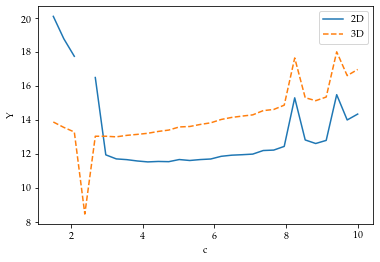

In [18]:
pl.figure()
ind = 8
pl.plot(c_dm_vals, 5e11*Y200sz_vals[ind,:], label='2D')
pl.plot(c_dm_vals, 5e11*Y200sz_3D_vals[ind,:], ls='--', label='3D')
pl.legend()
pl.xlabel('c')
pl.ylabel('Y')




